In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:01<00:00, 37.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 80.4MB/s]


Test Accuracy:  0.6357486631016043
Test Confusion Matrix: 
 [[12614     0  5364]
 [  386     5   299]
 [ 7574     0 11158]]


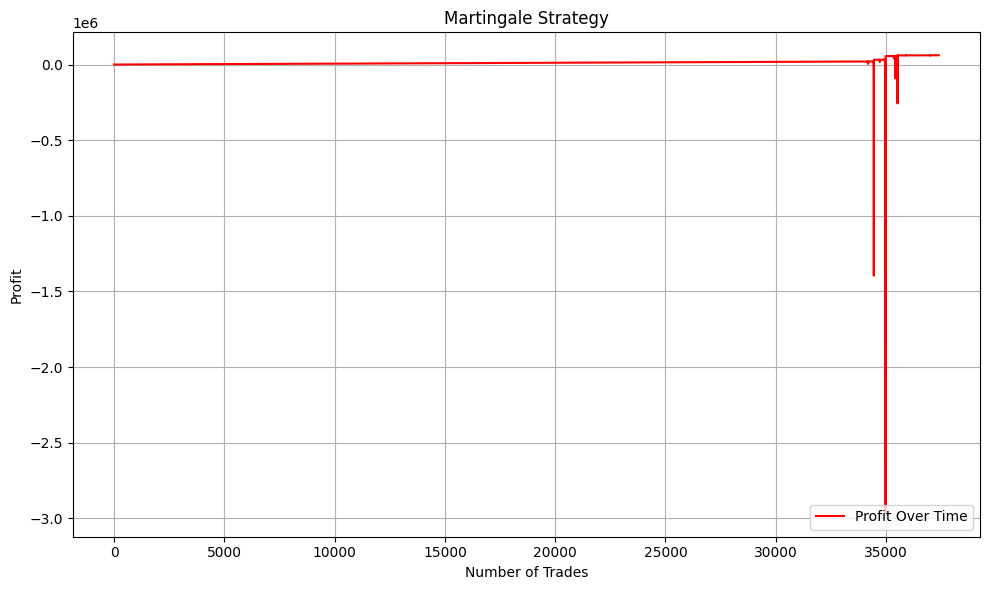

Martingale final profit: 61230.96


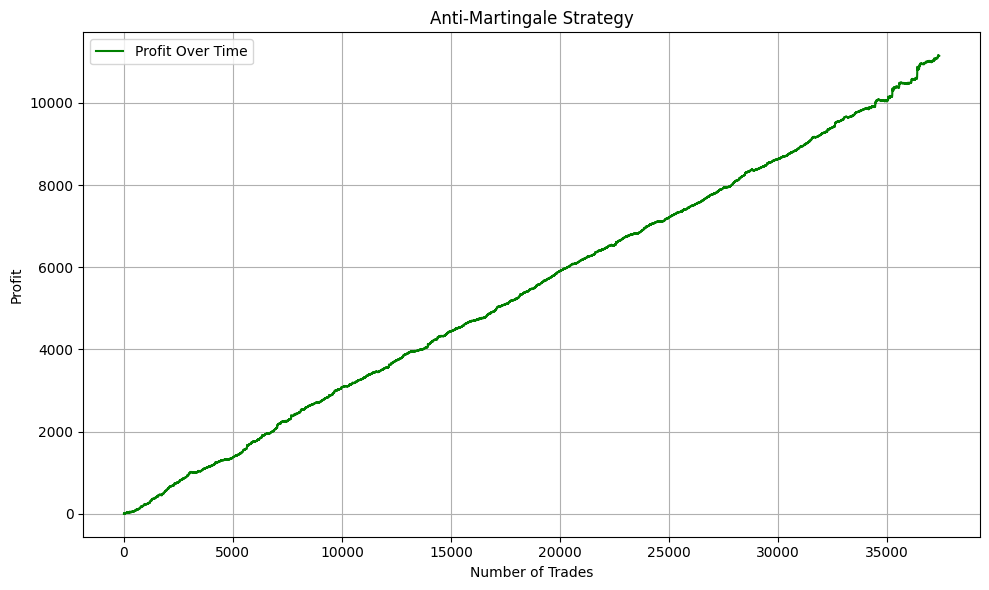

Anti-Martingale final profit: 11140.13
凱利最終本金: 5371531198325666539804277911492493312.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 3
run_analysis(shift_value)

Test Accuracy:  0.5728612307116305
Test Confusion Matrix: 
 [[10206     0  7673]
 [  153     0   227]
 [ 7919     0 11215]]


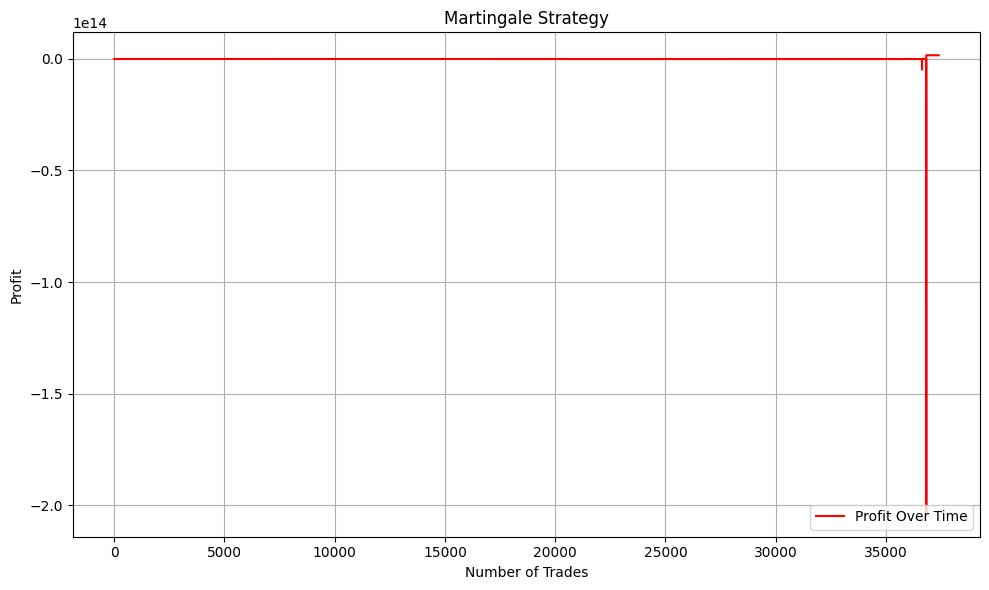

Martingale final profit: 1671095958865.21


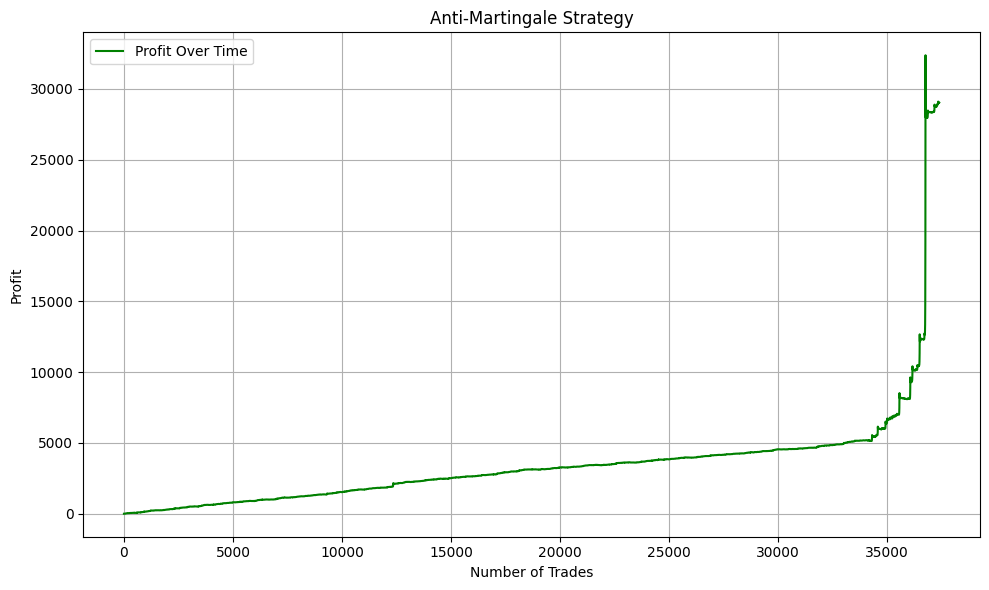

Anti-Martingale final profit: 29033.45
凱利最終本金: 25358275460.67


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 10
run_analysis(shift_value)

Test Accuracy:  0.5498221116550304
Test Confusion Matrix: 
 [[ 8875     0  8926]
 [   93     0   142]
 [ 7668     0 11679]]


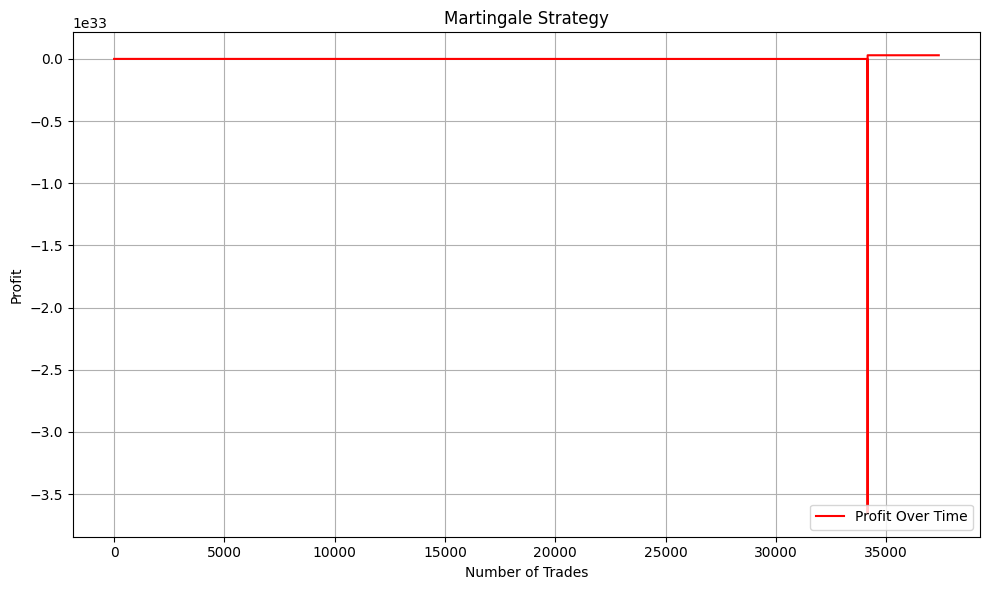

Martingale final profit: 29272892642658097772725962539008.00


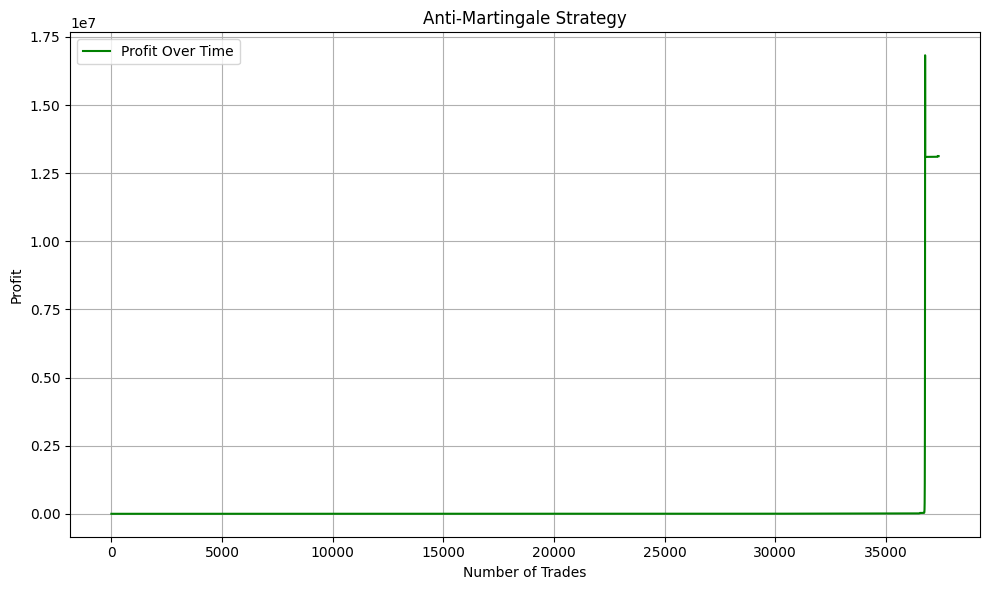

Anti-Martingale final profit: 13126220.33
凱利最終本金: 292296.02


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 20
run_analysis(shift_value)

Test Accuracy:  0.5372060043346801
Test Confusion Matrix: 
 [[ 9247     0  8429]
 [   79     0   132]
 [ 8656     0 10830]]


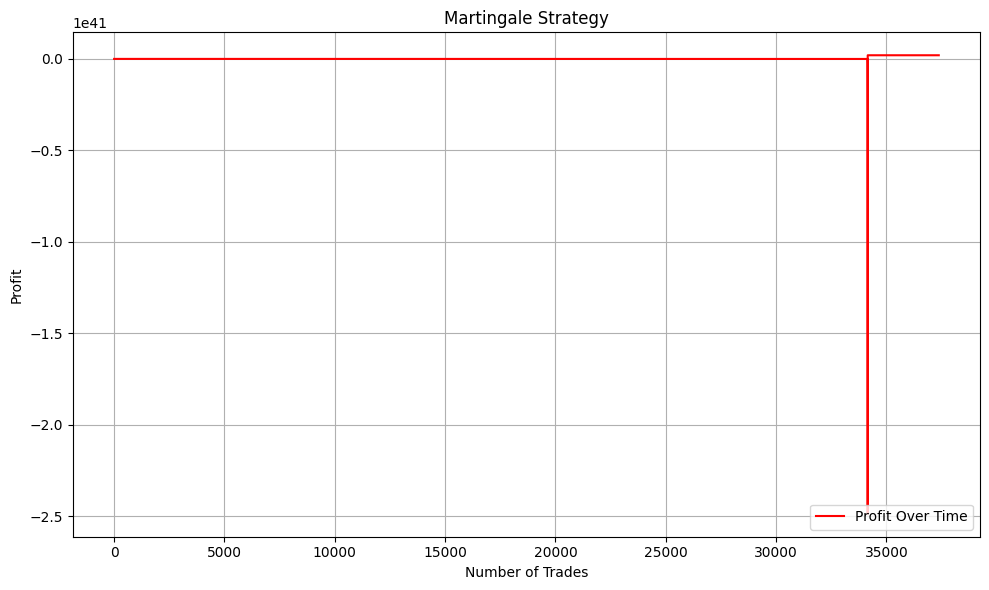

Martingale final profit: 1988503266186282618319876968440951472128.00


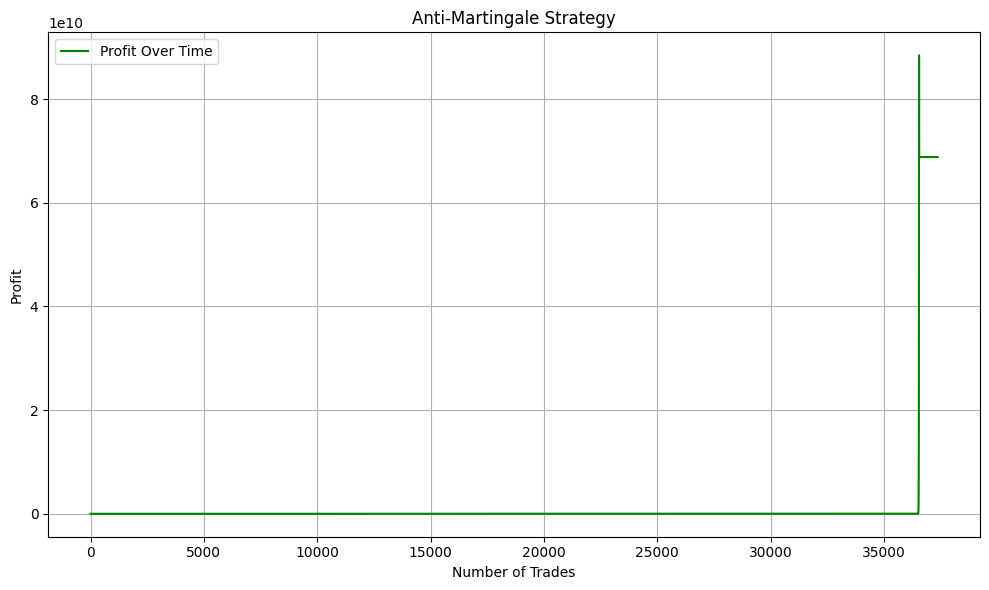

Anti-Martingale final profit: 68825774599.36
凱利最終本金: 17828.88


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 30
run_analysis(shift_value)

Test Accuracy:  0.5386344779594786
Test Confusion Matrix: 
 [[ 8599     0  8875]
 [   61     0   115]
 [ 8187     0 11526]]


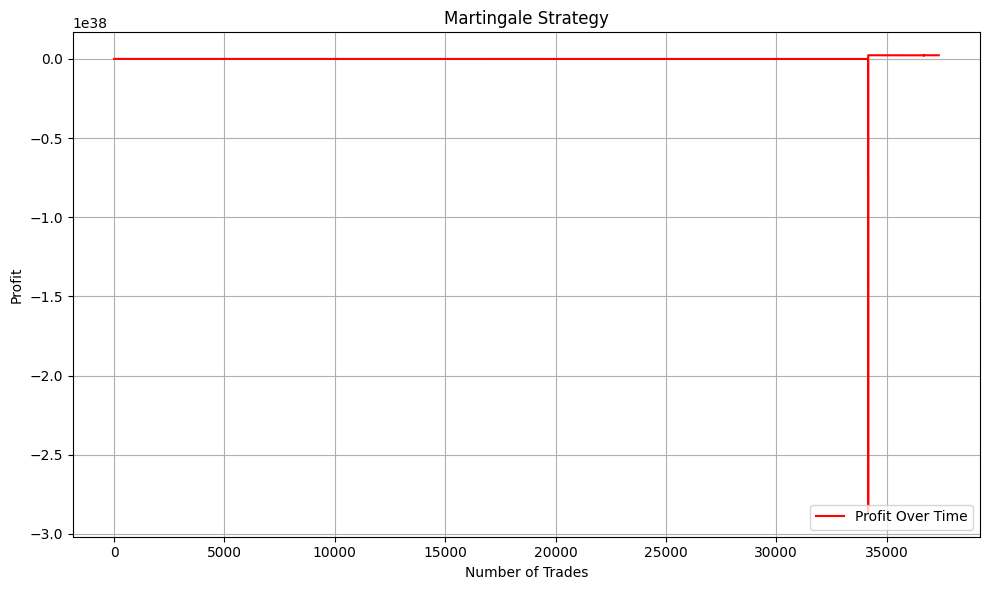

Martingale final profit: 2301470066899439487366100848073506816.00


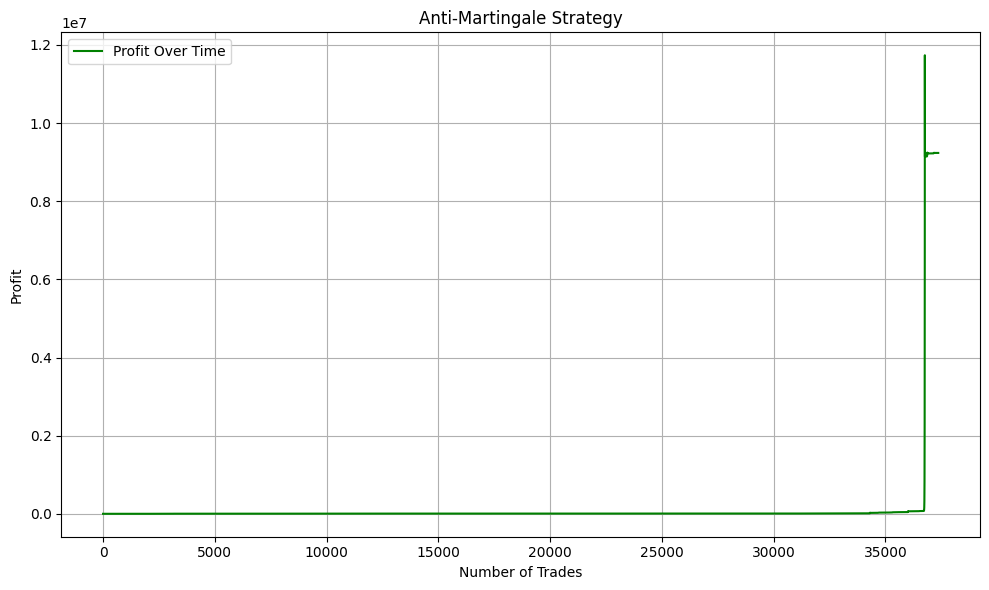

Anti-Martingale final profit: 9235481.15
凱利最終本金: 3241.04


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 40
run_analysis(shift_value)

Test Accuracy:  0.5354857708885498
Test Confusion Matrix: 
 [[ 8239     0  9111]
 [   66     0    76]
 [ 8098     0 11763]]


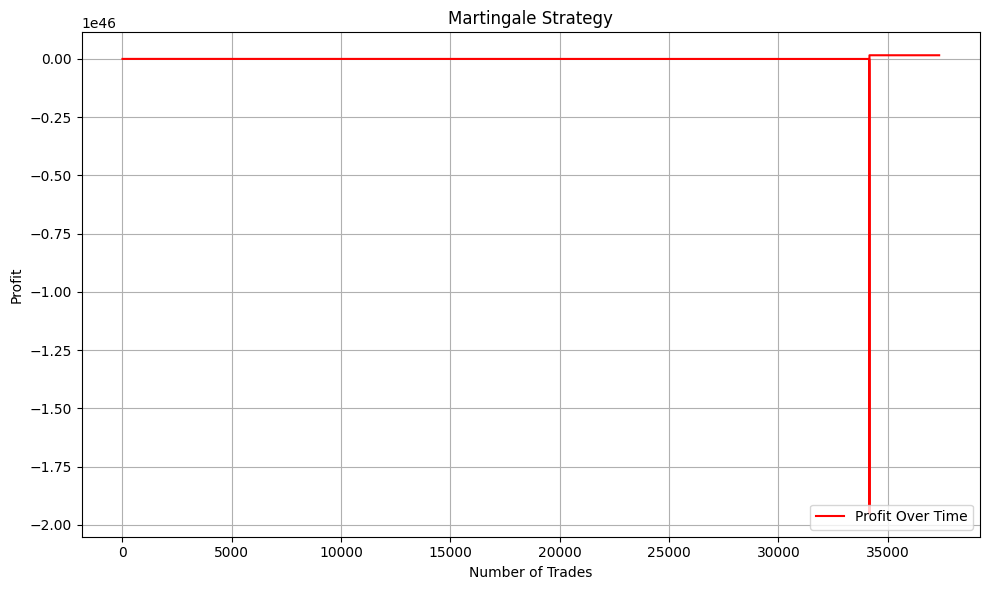

Martingale final profit: 156158038557289028626534903138578308882497536.00


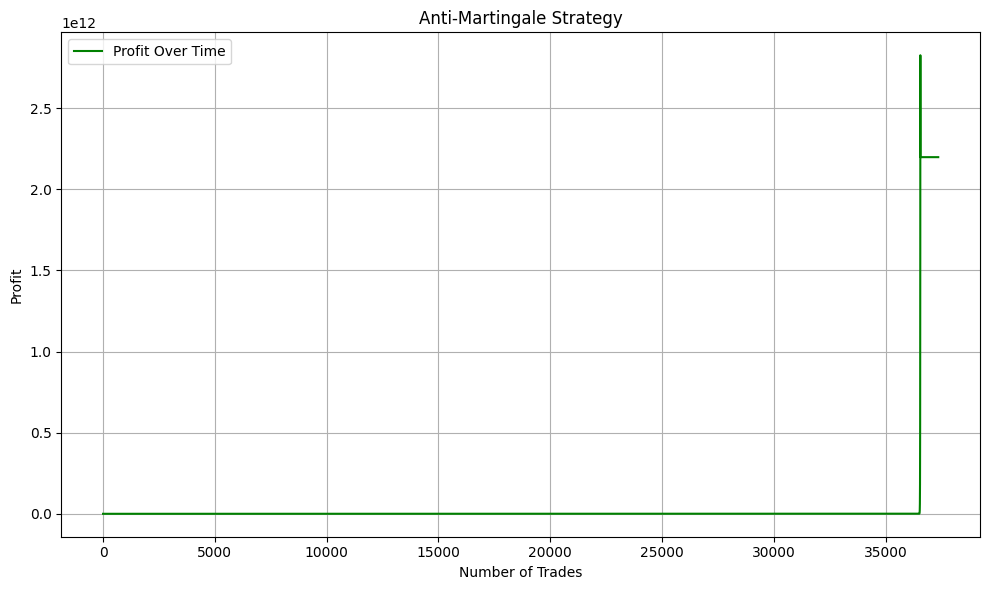

Anti-Martingale final profit: 2198256409866.69
凱利最終本金: 15905.37


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 50
run_analysis(shift_value)

Test Accuracy:  0.5315855715930696
Test Confusion Matrix: 
 [[ 7556     0  9750]
 [   41     0    94]
 [ 7607     0 12295]]


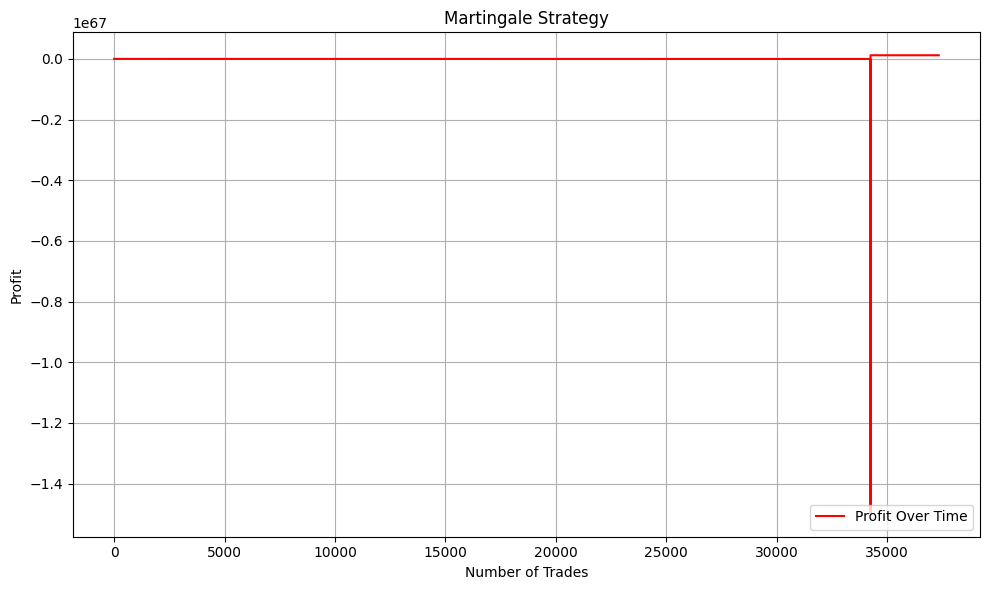

Martingale final profit: 119966314113545605799024151123349336380140119933738411814415237120.00


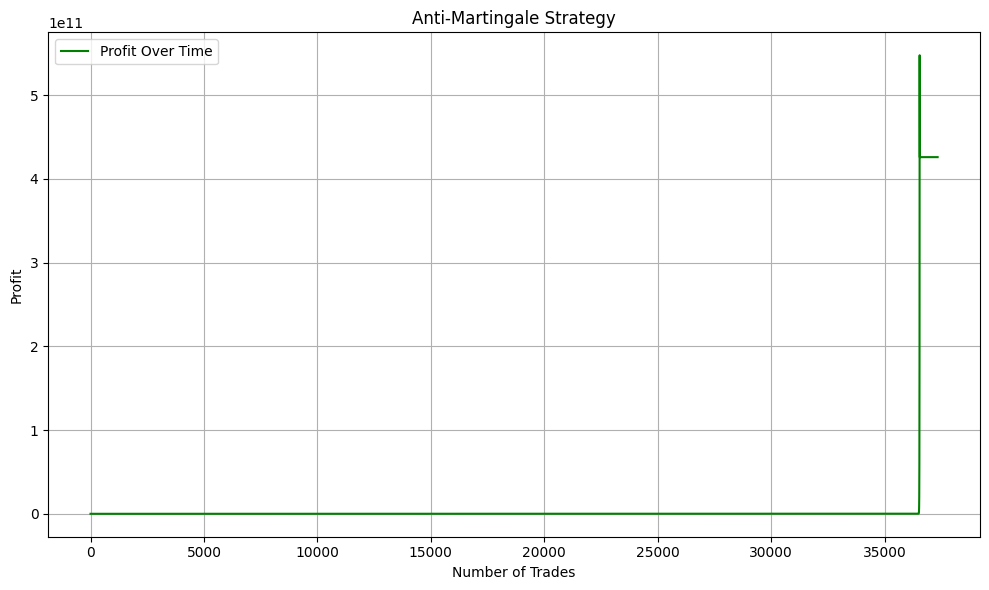

Anti-Martingale final profit: 426116305939.04
凱利最終本金: 8238.05


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 60
run_analysis(shift_value)

Test Accuracy:  0.5160528927393182
Test Confusion Matrix: 
 [[ 5765     0 11500]
 [   29     0    71]
 [ 6443     0 13475]]


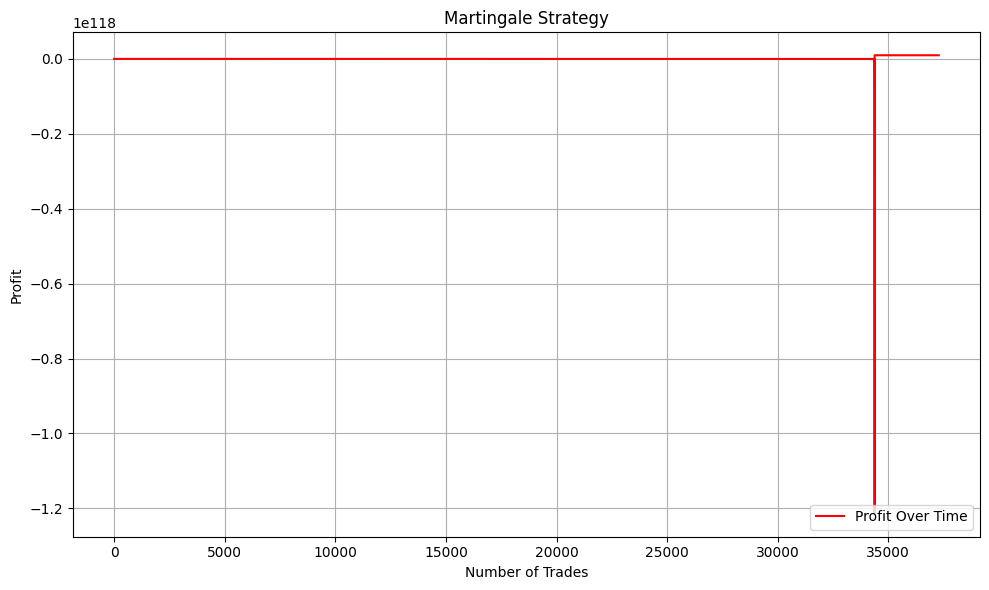

Martingale final profit: 97152419436773141560635569194457071378240580387026544554536442046579191965590483730205401654298882541119090680922112.00


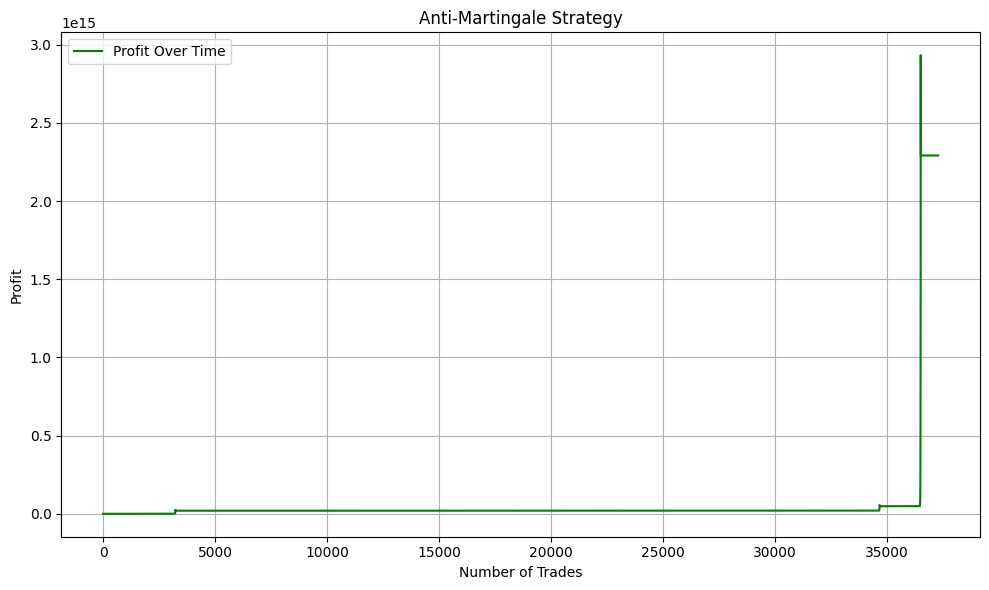

Anti-Martingale final profit: 2292043305795038.00
凱利最終本金: 15737.33


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 120
run_analysis(shift_value)

Test Accuracy:  0.4758765438742836
Test Confusion Matrix: 
 [[ 7548     0  9526]
 [   12     0    45]
 [ 9895     0 10137]]


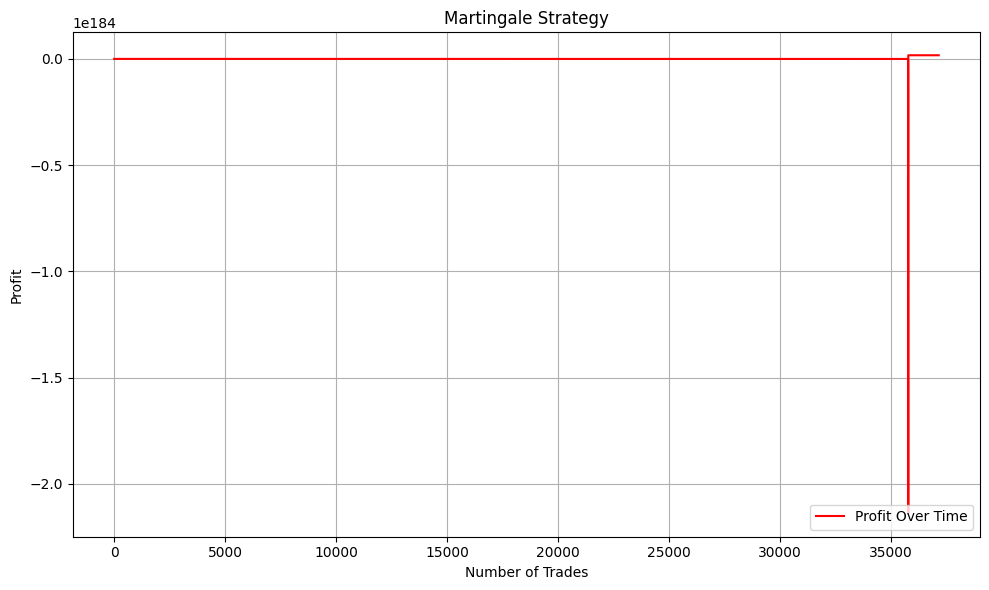

Martingale final profit: 171251107603947558214604870306734667599418824512893399998282468463559654807231121982330834857651020210033740239183957099835870901205467134695409400343979125893527165089725093074960384.00


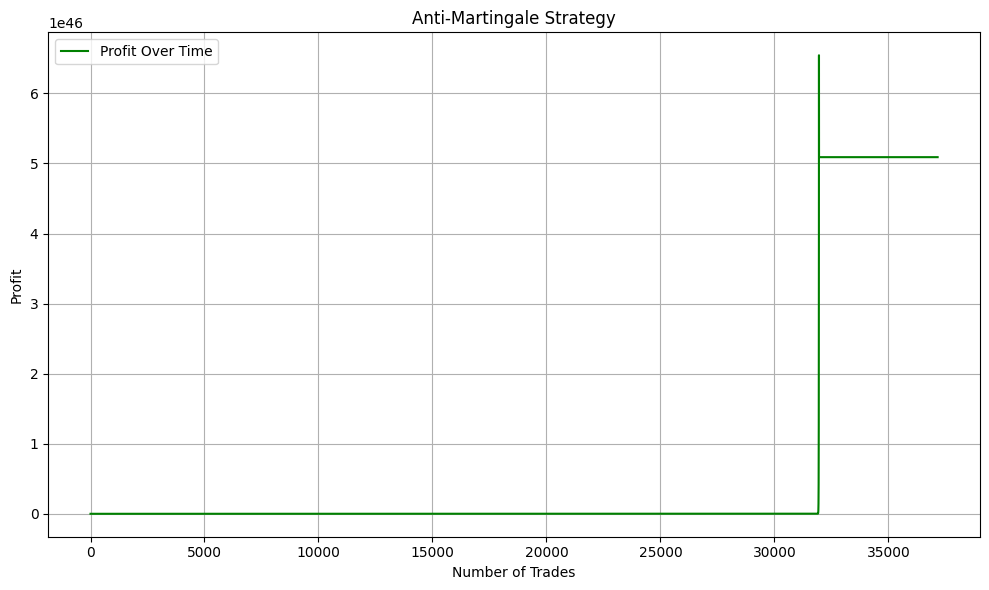

Anti-Martingale final profit: 50901966107037448600240921822513805829104205824.00
凱利最終本金: 57492.73


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 240
run_analysis(shift_value)

Test Accuracy:  0.5050886807224036
Test Confusion Matrix: 
 [[ 8562     0  8794]
 [   18     0    30]
 [ 9491     0 10148]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


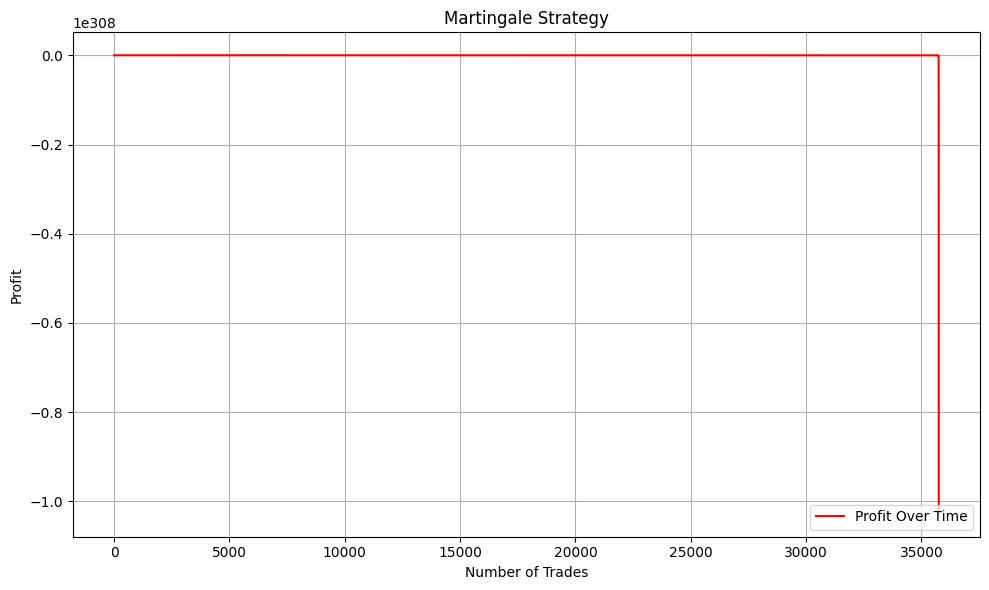

Martingale final profit: nan


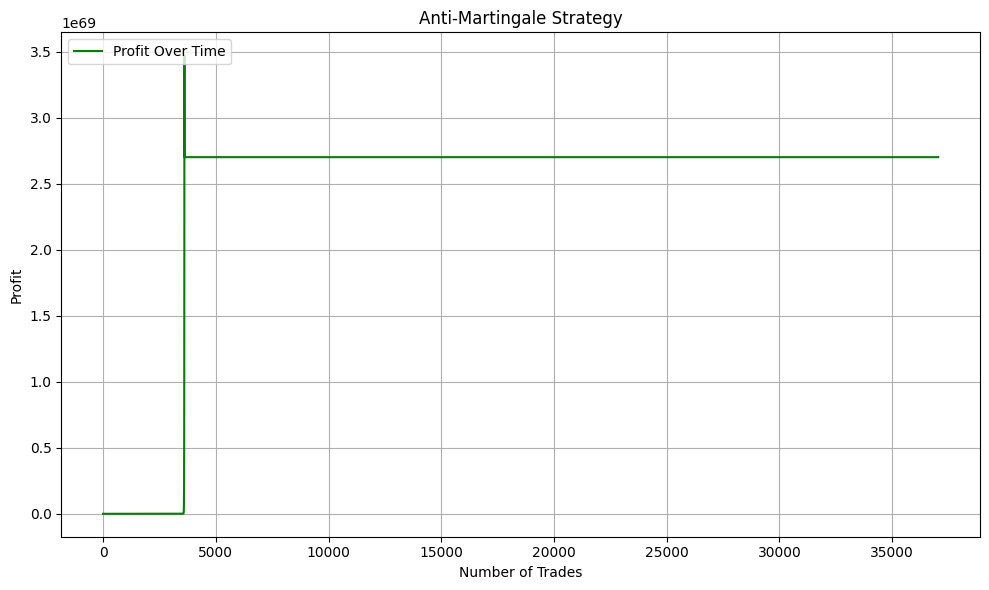

Anti-Martingale final profit: 2702415391766549726263016977226326531257937303531916923002943019417600.00
凱利最終本金: 13048125.63


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 360
run_analysis(shift_value)

Test Accuracy:  0.475746824472551
Test Confusion Matrix: 
 [[ 7252     0  9919]
 [   22     0    34]
 [ 9382     0 10314]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


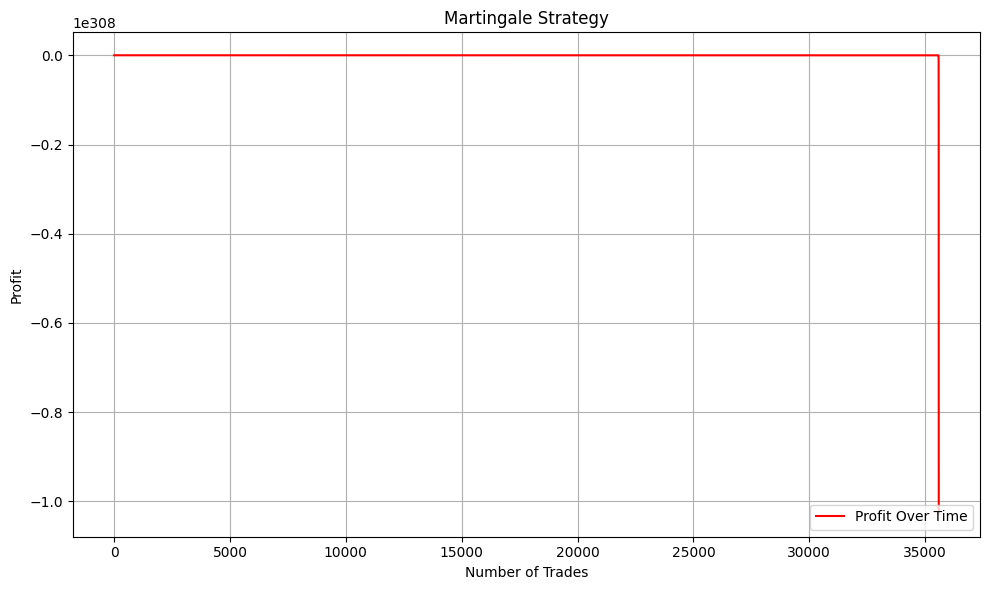

Martingale final profit: nan


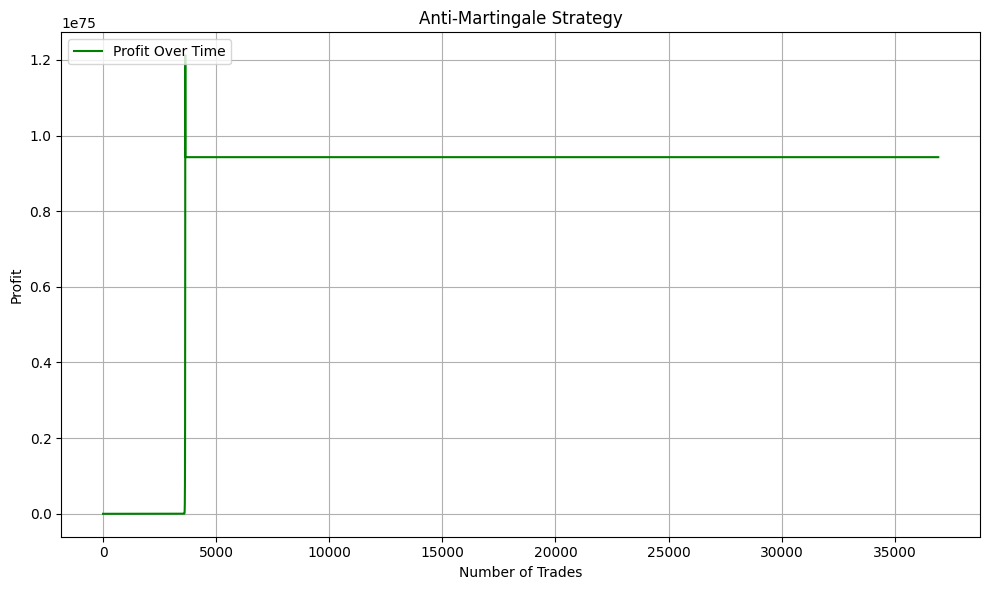

Anti-Martingale final profit: 942842887244362684297127304561989140789947473545555858680934680176168534016.00
凱利最終本金: 17346460308078964.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 480
run_analysis(shift_value)

Test Accuracy:  0.46963562753036436
Test Confusion Matrix: 
 [[ 7044     0  9922]
 [   17     0    27]
 [ 9553     0 10240]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


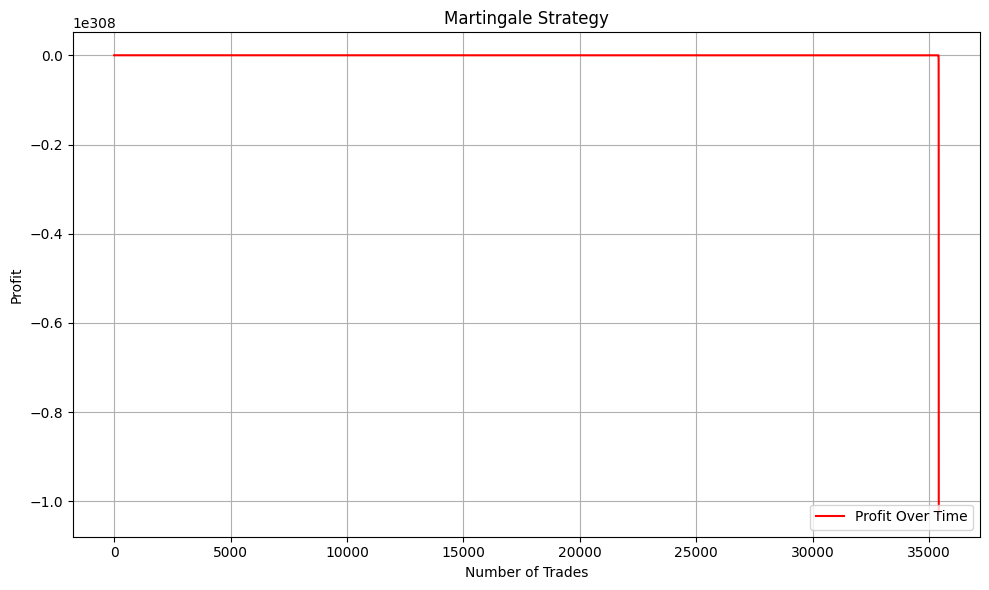

Martingale final profit: nan


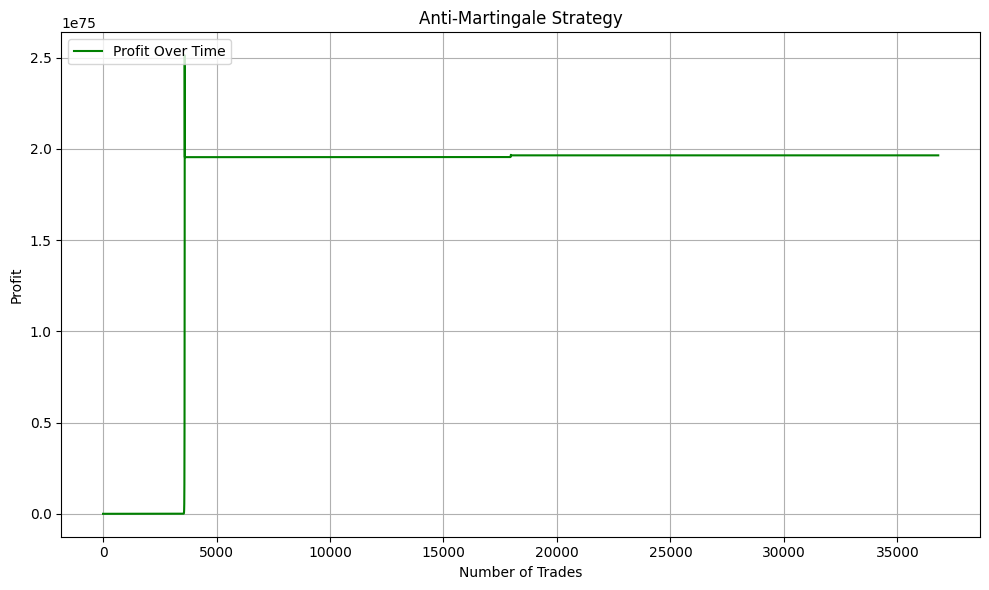

Anti-Martingale final profit: 1964962452050271397649252980043254906427142090182056583263272999882596548608.00
凱利最終本金: 23257.04


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 600
run_analysis(shift_value)

Test Accuracy:  0.4414578960281329
Test Confusion Matrix: 
 [[ 4675     0 12006]
 [   18     0    21]
 [ 8444     0 11519]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


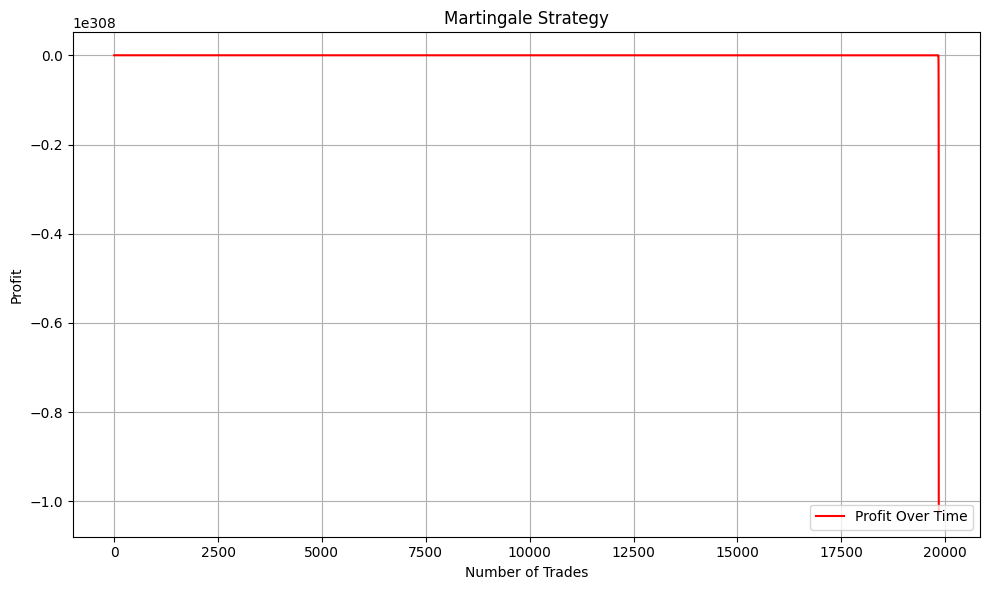

Martingale final profit: nan


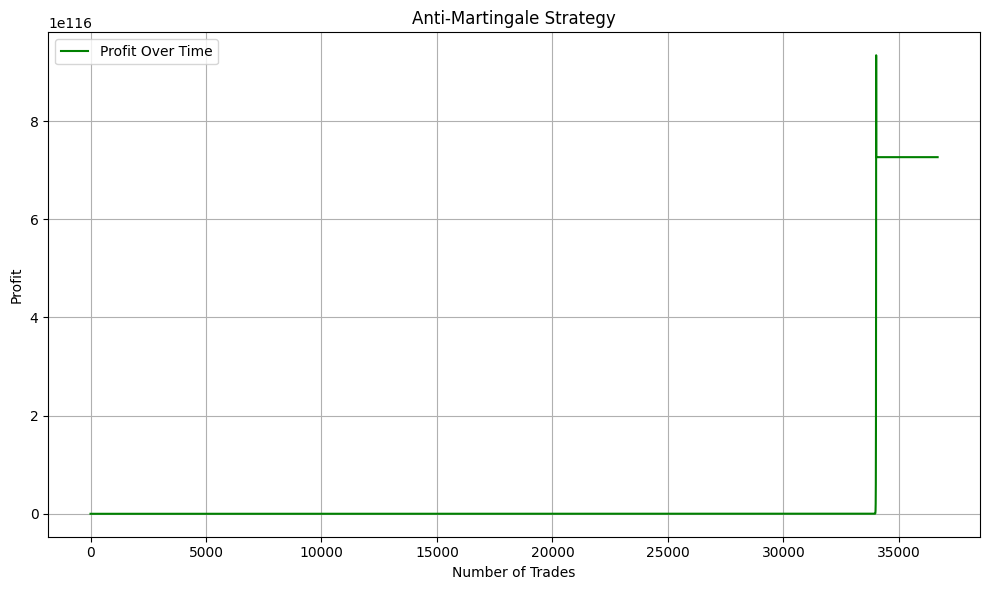

Anti-Martingale final profit: 726638639948817222631239397020219664320644358009532803621100994754699034182003159235767150138282616410336096679886848.00
凱利最終本金: 42.09


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 720
run_analysis(shift_value)

Test Accuracy:  0.451549380521292
Test Confusion Matrix: 
 [[ 4983     0 11307]
 [   23     0    15]
 [ 8708     0 11527]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


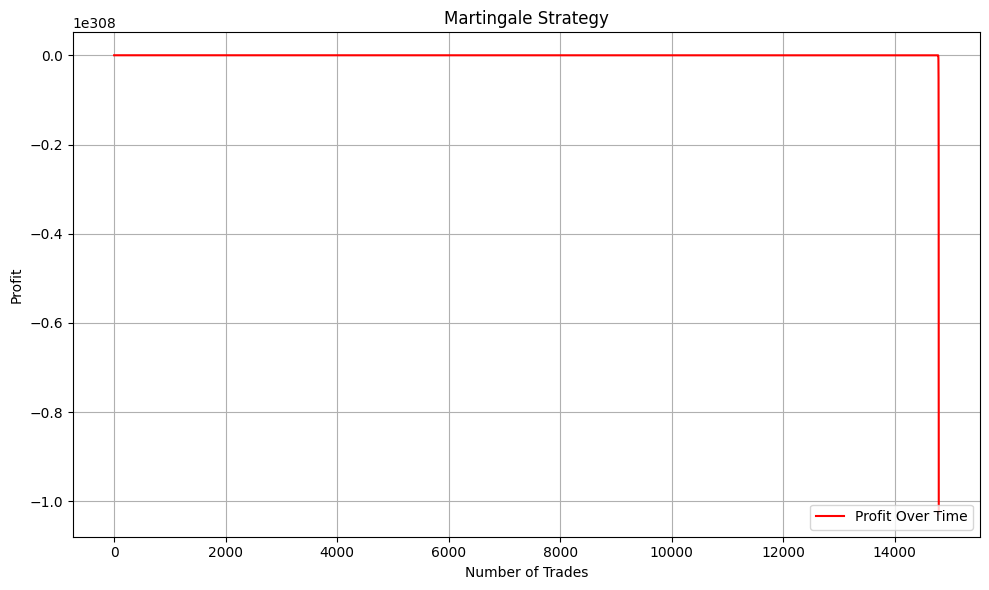

Martingale final profit: nan


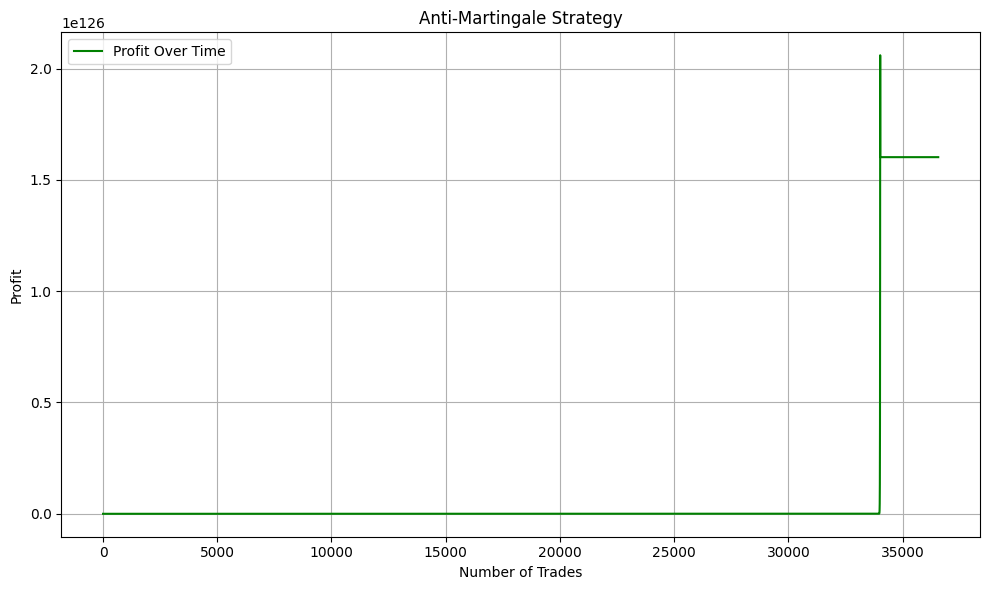

Anti-Martingale final profit: 1602158661294164459169799179088770420434318056673240615272583788974907751617566146059128899782965577333274173512955911412383744.00
凱利最終本金: 1348627.90


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 840
run_analysis(shift_value)

Test Accuracy:  0.47334193123507945
Test Confusion Matrix: 
 [[ 5398     0 10320]
 [   15     0    19]
 [ 8839     0 11852]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


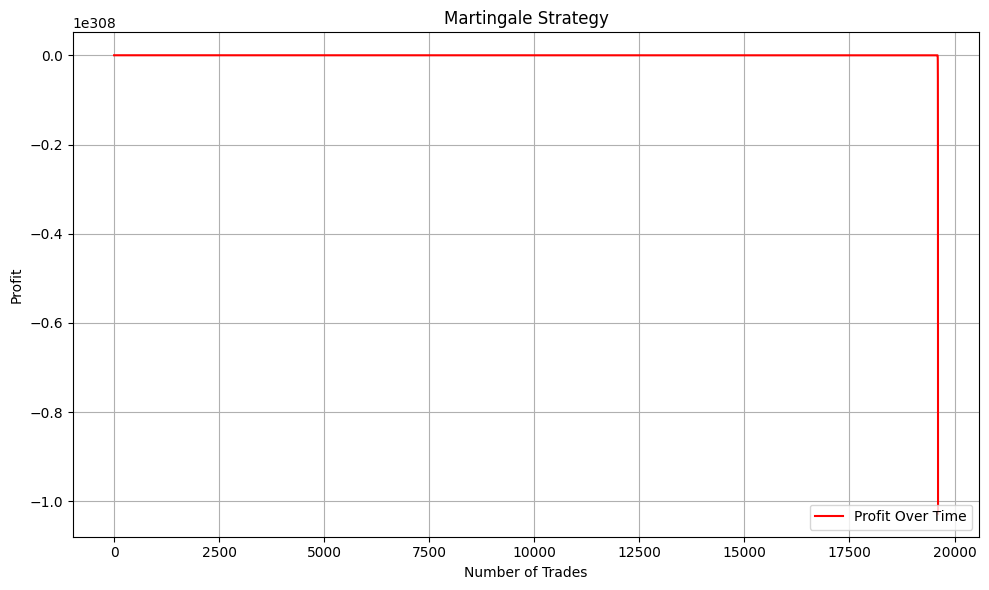

Martingale final profit: nan


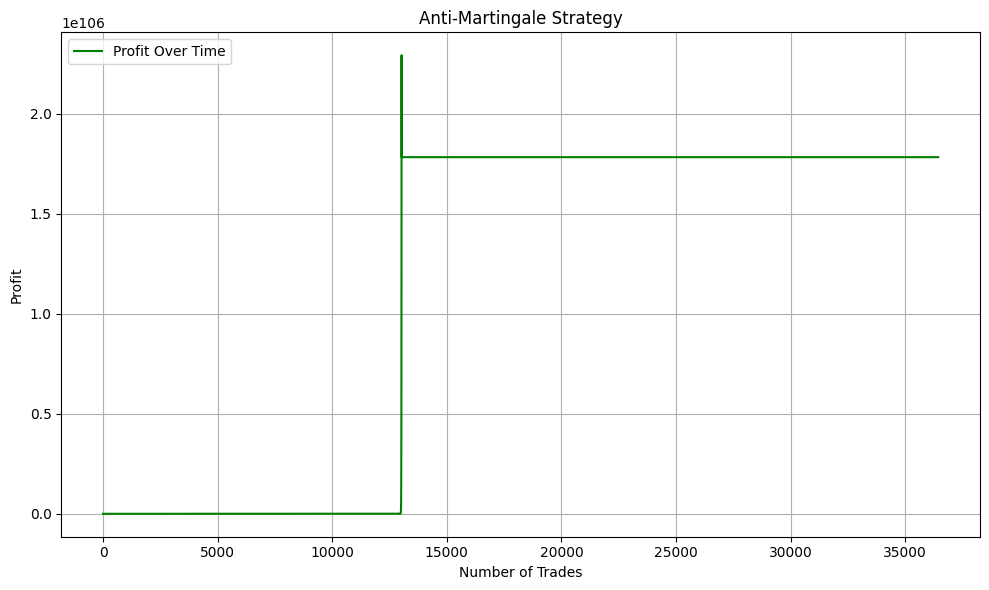

Anti-Martingale final profit: 17825081268091411251099317246034635647495654727521357862717746923695191226952780236773309419170839811588096.00
凱利最終本金: 2248838939845763840.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 960
run_analysis(shift_value)

Test Accuracy:  0.5079976874156871
Test Confusion Matrix: 
 [[ 6042     0  9217]
 [   22     0    15]
 [ 8617     0 12410]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


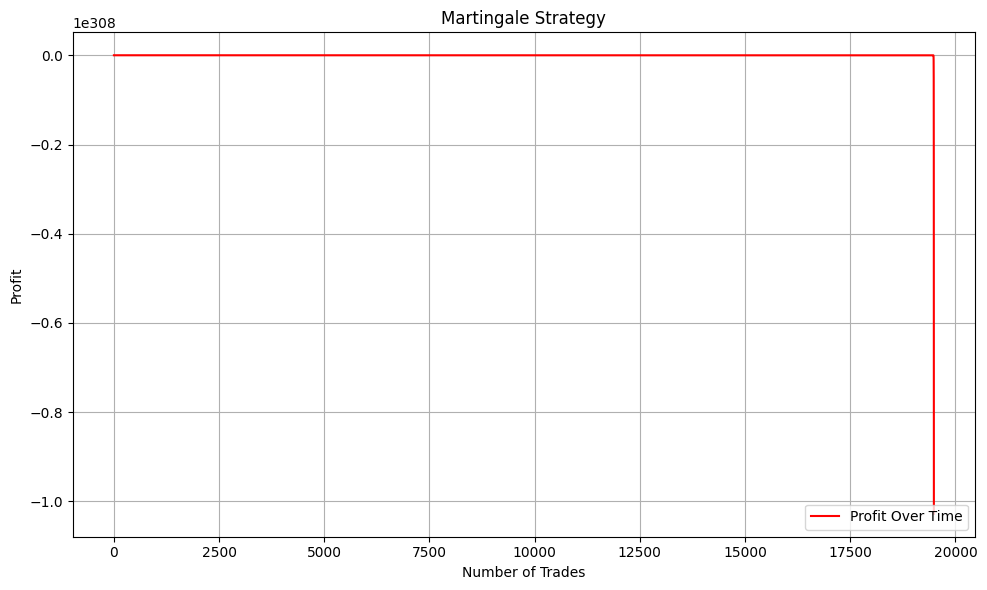

Martingale final profit: nan


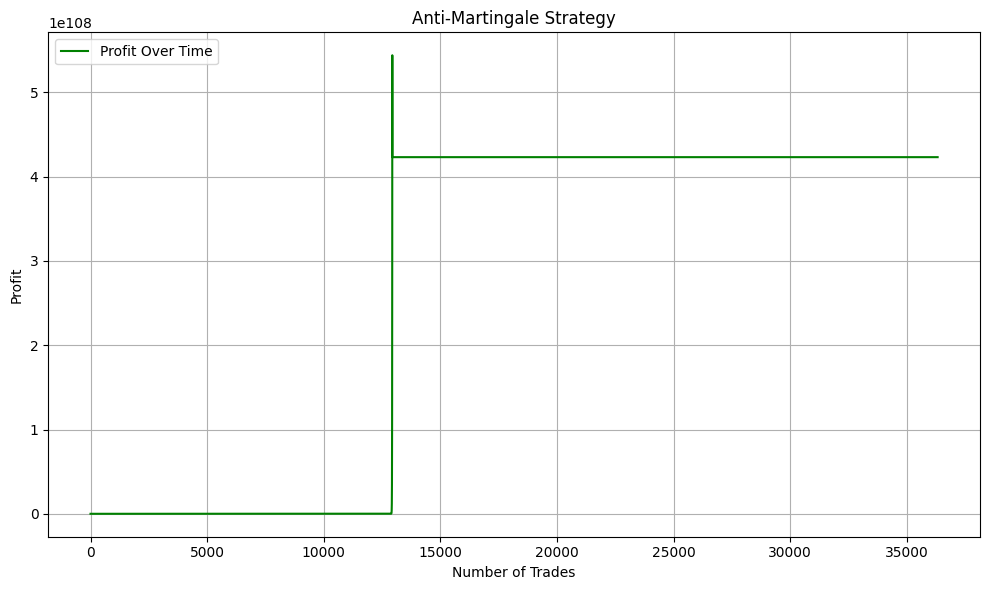

Anti-Martingale final profit: 4231252084527989369131757162201994815234893653613037701422783050082344209102322769203472183370248088696389632.00
凱利最終本金: 3850249529351426023620608.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1080
run_analysis(shift_value)

Test Accuracy:  0.49430876339927066
Test Confusion Matrix: 
 [[ 6226     0  8462]
 [   27     0    16]
 [ 9799     0 11666]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


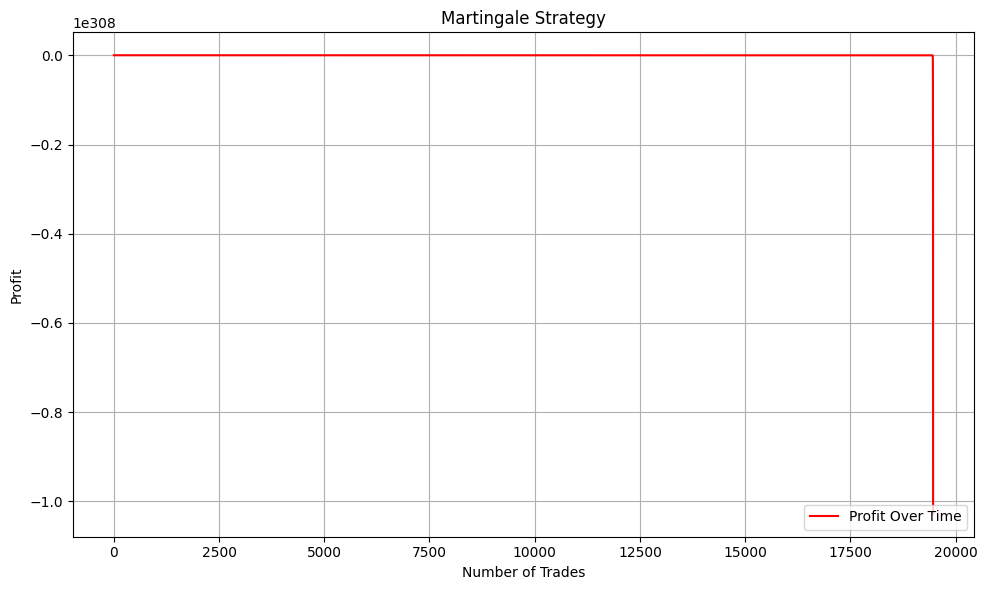

Martingale final profit: nan


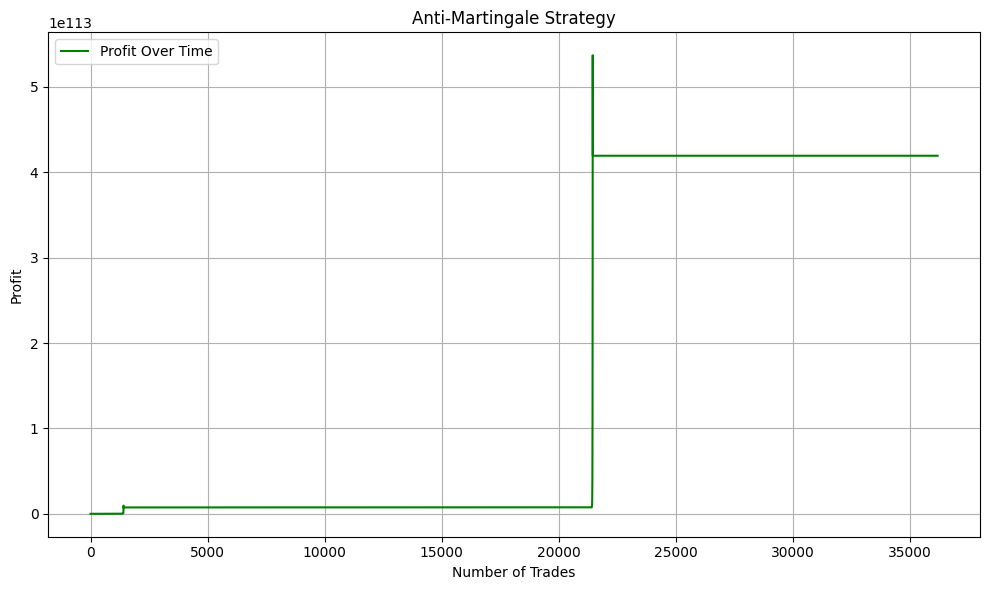

Anti-Martingale final profit: 419459550122814440302816941554624163052933176415782420716917434951326250348284300287837802144551151116168709799936.00
凱利最終本金: 2213173862.92


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1200
run_analysis(shift_value)

Test Accuracy:  0.453804347826087
Test Confusion Matrix: 
 [[ 6009     0  8545]
 [   19     0    12]
 [11122     0 10357]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


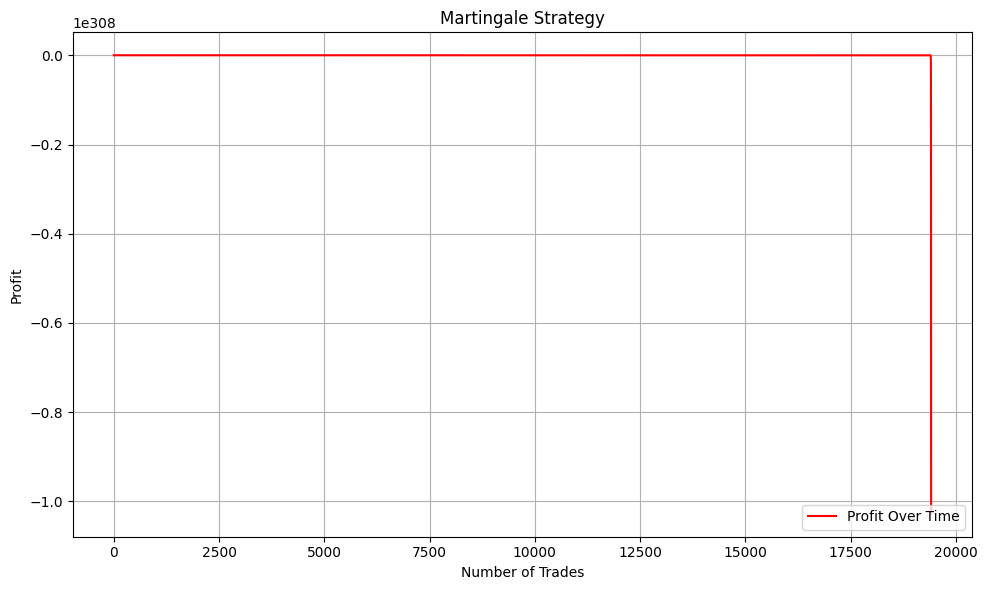

Martingale final profit: nan


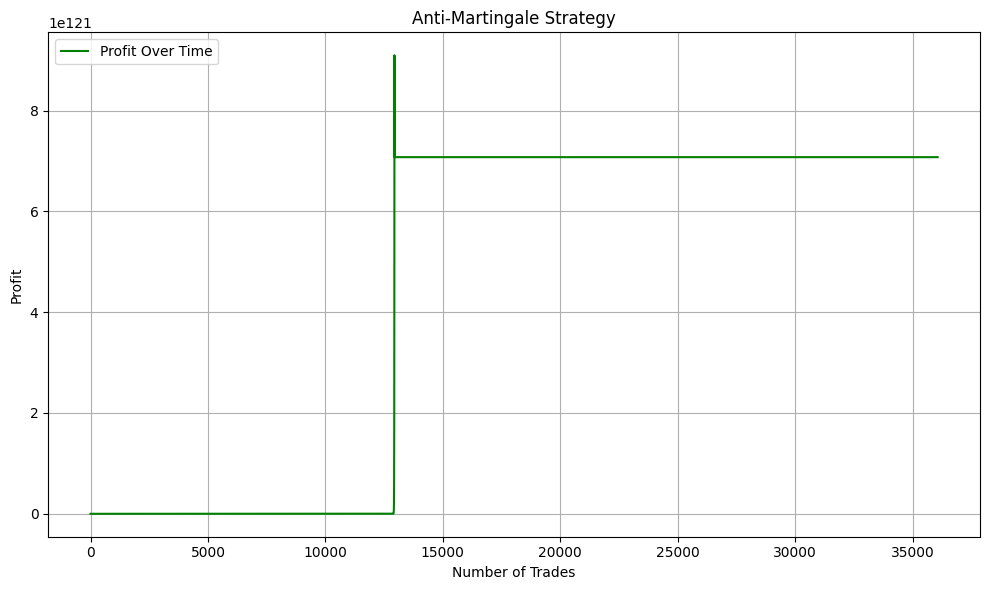

Anti-Martingale final profit: 70751717906971907143841248637012838789679511023430262909918505522987550348236231150480533428401528957345345696599245848576.00
凱利最終本金: 7402.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=6,
        min_samples_leaf=1,
        random_state=0
    )

    # 訓練模型
    rf_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = rf_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = rf_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = rf_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1320
run_analysis(shift_value)